# Goal

The idea of this notebook is to pre-process the image in order to make is easier to segment. Here are few things that we are going to do:

- Try to improve the contrast of the image by thresholding/playing with the intensity distribution (automatically)
- Try to "remove" background by segmenting algea that are in the middle of the image
- Removing pixels that are static ?

## Import the necessary packages

In [1]:
import skimage
import napari
from tifffile import imread,imwrite
from pathlib import Path
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage.measure as sm
import seaborn as sns
import os
from scipy.optimize import curve_fit
from skimage.measure import label, regionprops, regionprops_table
from scipy import ndimage
from matplotlib import animation
from IPython.display import HTML
import matplotlib as cm
from skimage.segmentation import morphological_chan_vese,checkerboard_level_set
from skimage.filters import rank,gaussian
from skimage.morphology import disk
from skimage import exposure
from skimage import img_as_float

### Load a "raw image"

In [229]:
path = Path('../data/tricho_wound.tif')
im = imread(path)[700:800,...].astype('uint8')
print(np.shape(im))

(100, 576, 576)


In [230]:
def plotting(n_row,n_col,img,plane):
    _, axs = plt.subplots(n_row, n_col, figsize=(12, 12))
    axs = axs.flatten()
    for plane, ax in zip(plane, axs):
        ax.imshow(img[plane])
        ax.axis('off')
        
    return axs

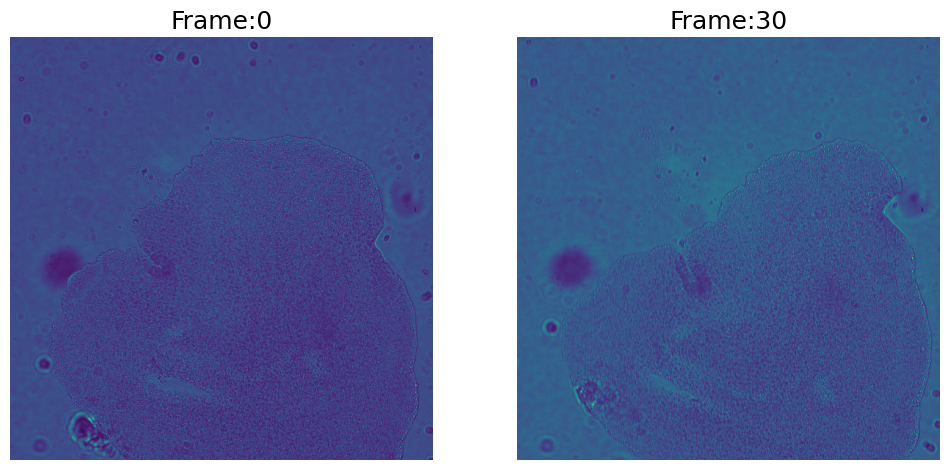

In [231]:
m = plotting(1,2,im,[0,30])

title = [0,30]

for i,ax in enumerate(m):
    ax.set_title(f'Frame:{title[i]}')

# Segmenting the algae 

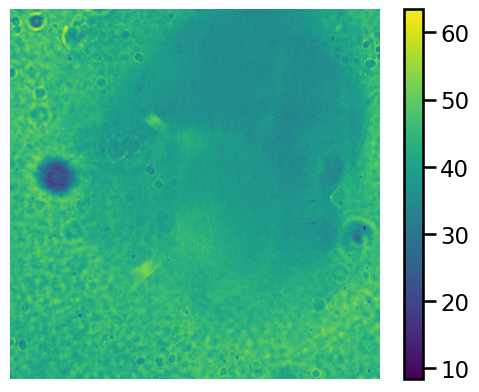

In [232]:
#projecting the image in order to average all plane and get the position of the static elements

im_p = np.mean(im,axis=0)
plt.axis('off')
plt.imshow(im_p,origin='lower')
plt.colorbar()
plt.show()


In [233]:
# segment 
def segm_alg(im_p):
    #gaussian blurr
    image = gaussian(im_p,sigma=1)
    #image = im_p
    #segment using also a smoothing
    im_ms = morphological_chan_vese(image,num_iter=20,smoothing=2)
    
    #fill holes and dilate to remove noise
    ms_filled = ndimage.binary_fill_holes(im_ms)
    ms_filled = ndimage.binary_dilation(ms_filled)
    #ms_filled = im_ms
    
    #label connected components in the binary mask
    labels, num_features = ndimage.label(ms_filled)
    label_unique = np.unique(labels)

    #count pixels of each component and sort them by size, excluding the background
    vol_list = []
    for label in label_unique:
        if label != 0:
            vol_list.append(np.count_nonzero(labels == label))

    #create binary array of only the largest component
    binary_mask = np.zeros(labels.shape)
    binary_mask = np.where(labels == vol_list.index(max(vol_list))+1, 1, 0)
    #binary_mask = np.where(labels == vol_list.index(min(vol_list))+1, 1, 0)

    
    #remove the largest component from the image
    
    m = ms_filled - binary_mask
    
    #m = binary_mask
    
    return m

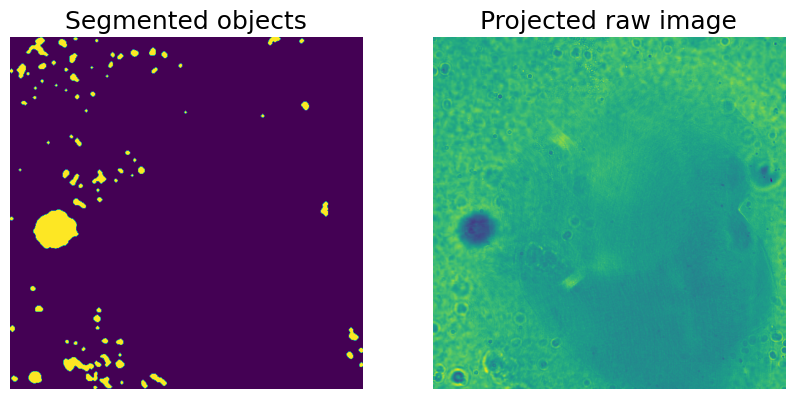

In [234]:
m = segm_alg(im_p)

fig,ax = plt.subplots(1,2,figsize=(10,5))

ax[0].imshow(m)
ax[1].imshow(im_p)

l = ['Segmented objects','Projected raw image']

for j,ax in enumerate(ax):
    ax.axis('off')
    ax.set_title(l[j])
plt.show()

In [6]:
lab = label(m)
props = regionprops_table(label_image=lab, intensity_image = im_p, properties=('centroid','area','slice','intensity_mean'))

df = pd.DataFrame(props)
df#.head()

,centroid-0,centroid-1,area,slice,intensity_mean
0,6.035503,429.751479,169,"(slice(0, 15, None), slice(421, 442, None))",40.549763
1,17.800000,45.720879,455,"(slice(2, 33, None), slice(26, 63, None))",40.441187
2,4.000000,106.500000,28,"(slice(2, 7, None), slice(103, 111, None))",40.021786
3,7.500000,475.500000,46,"(slice(4, 12, None), slice(472, 480, None))",40.272174
4,11.194245,85.697842,139,"(slice(5, 19, None), slice(79, 93, None))",39.765036
...,...,...,...,...,...
79,558.666667,6.960000,75,"(slice(554, 564, None), slice(2, 13, None))",38.164933
80,564.839806,156.174757,206,"(slice(556, 575, None), slice(146, 167, None))",40.018641
81,567.812500,218.406250,96,"(slice(561, 575, None), slice(214, 225, None))",40.654687
82,565.000000,182.000000,23,"(slice(562, 569, None), slice(180, 185, None))",39.500000


AxesSubplot(0.31875,0.11;0.0341912x0.77)


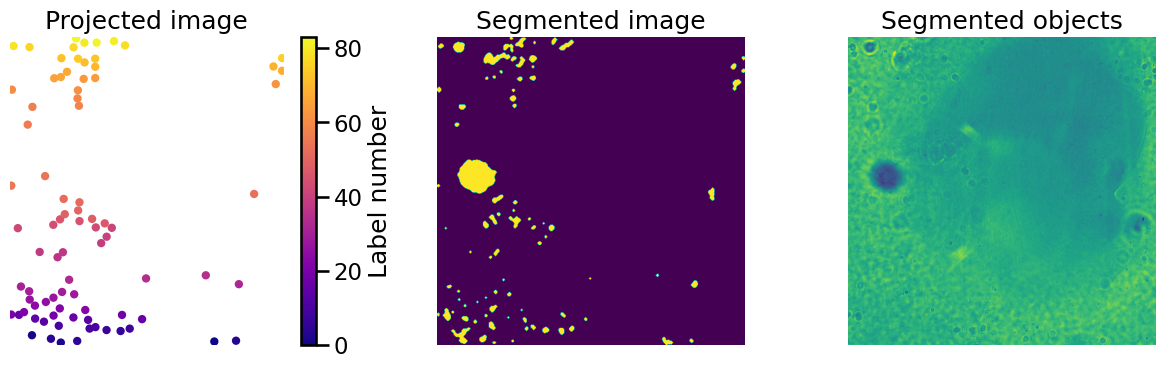

In [115]:
sns.set_context("talk")

fix,ax = plt.subplots(1,3,figsize=(15,4),sharex=True,sharey=True)

c = [x for x in df.index.values]

s = ax[0].scatter(df['centroid-1'],df['centroid-0'],marker='.',c=c,cmap='plasma')
ax[1].imshow(m,origin='lower')
ax[2].imshow(im_p,origin='lower')

title = ['Projected image','Segmented image','Segmented objects']

fig.colorbar(s, ax=ax[0])

for ax,t in zip(ax,title):
    ax.axis('off')
    ax.set_title(t)
    
f = plt.gcf()

cax = f.get_axes()[-1]
print(cax)
cax.set_ylabel('Label number')
fig.tight_layout()
#plt.savefig('../data/results/figures/contrast_enhancement/algea_detection_automatic.png',dpi=300)
plt.show()

## Test to remove the algae

In [116]:
mask = imread('../data/results/chan_vese/placozoan-movie_wound_masked_chanvese.tif')[700:800,...]

random color map:

viridis = cm.colormaps['viridis'].resampled(len(position.index))


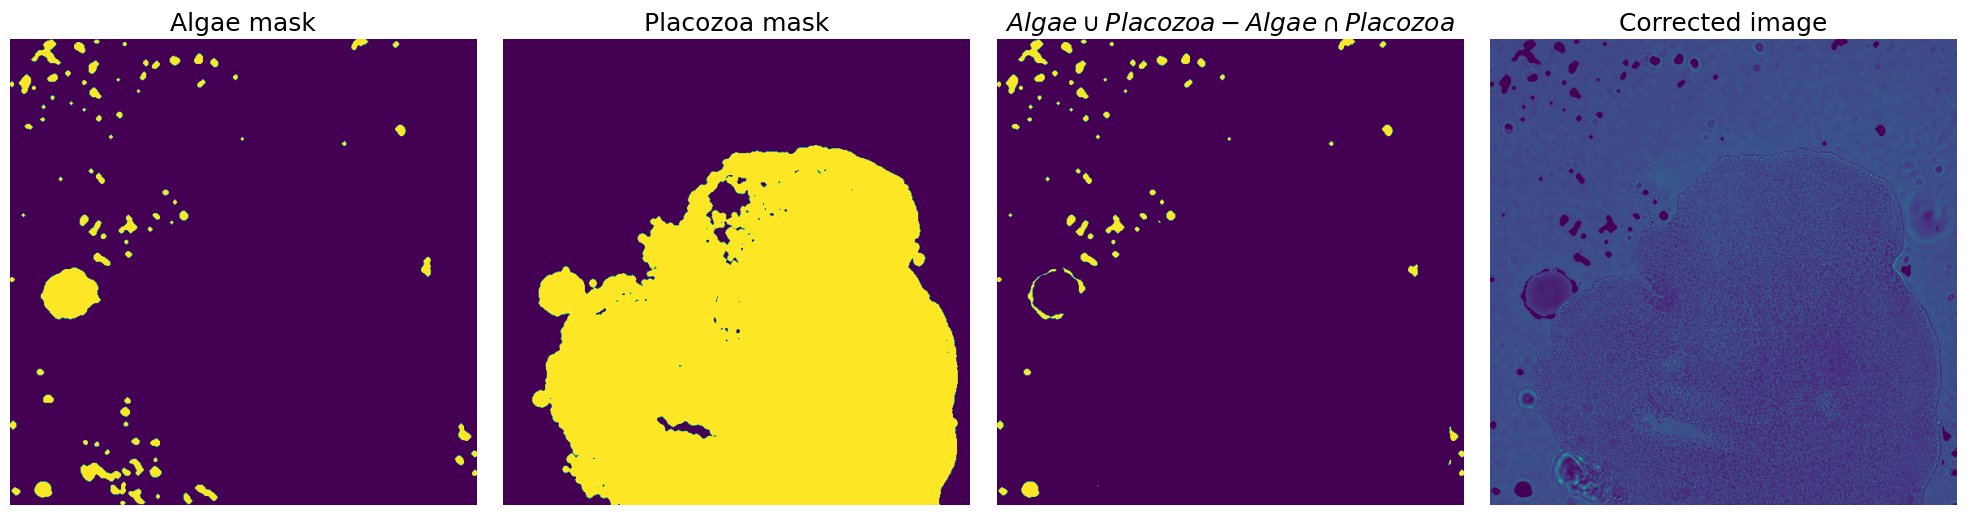

In [117]:
sns.set_context("talk")
fig,ax = plt.subplots(1,4, figsize=(20,7))

#create the mask by subtracting the algae and the environment

ma = m.copy()

mask_img = ma * (mask[3,...] == 0.)

#correct the image based on the substraction

im_test = im[3,...].copy()

newImage = im_test * (mask_img==0)

# plot 

ax[0].imshow(ma)
ax[1].imshow(mask[3,...])
ax[2].imshow(mask_img)
ax[3].imshow(newImage)

lab = ['Algae mask','Placozoa mask','$Algae\cup Placozoa - Algae\cap Placozoa$','Corrected image']
for k,ax in enumerate(ax):
    ax.set_title(lab[k])
    ax.axis('off')
    
fig.tight_layout()
#plt.savefig('../data/results/figures/contrast_enhancement/algea_removal_automatic_proof_of_concept.png',dpi=300)

In [118]:
def correct(mask_alg,mask_plac,raw_img):
    
    #initialize the corrected raw image
    
    new_image = np.zeros_like(raw_img) 
    
    for plane in range(np.shape(raw_img)[0]):
        
        #create the mask by subtracting the algae and the environment

        mask_img = mask_alg * (mask_plac[plane,...] == 0.)

        #correct the image based on the substraction

        new_image[plane,...] = raw_img[plane,...] * (mask_img == 0.)
        
        new_image[plane,...][new_image[plane,...] == 0] = 50 # change the value of the algae by 50 (arbitrary)
        
    #'''
        
    return new_image

In [119]:
def getalg(mask_alg,mask_plac,raw_img):
    '''
    get the algae for each plane that doesn't intersect with the organism
    for each plane tak only the difference between the mask of organism and mask of algaes
        
    '''
    #initialize the corrected raw image
    
    mask_img = np.zeros_like(raw_img) 
    
    for plane in range(np.shape(raw_img)[0]):
        
        #create the mask by subtracting the algae and the environment
        mask_img[plane,...] = mask_alg * (mask_plac[plane,...] == 0.)

    return mask_img

In [120]:
contr = getalg(ma,mask,im)

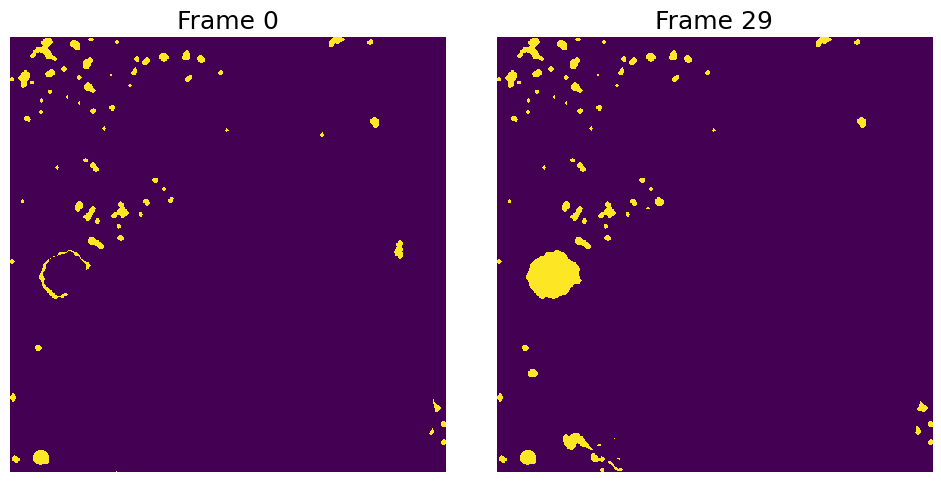

In [121]:
fig,ax = plt.subplots(1,2, figsize=(10,5))

for i,ax in zip([ 1 ,30],ax):
    ax.imshow(contr[i,...], interpolation='nearest')
    ax.set_title(f'Frame {i-1}')
    ax.axis('off')
    
fig.tight_layout()
#plt.savefig('../data/results/figures/contrast_enhancement/algea_removal_automatic_corrected_image.png',dpi=300)

## New idea 

The idea is to remove the organism from the image using the mask and then segment the algae to have them at time t

#### creating the removed image

In [235]:
im_test = im[3,...].copy()

new_image = im_test * (mask[3,...]==0.)

new_image[new_image == 0] = np.mean(im_test)


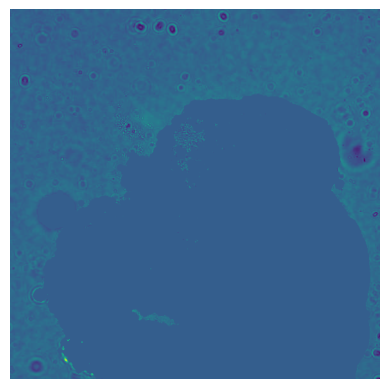

In [236]:
figures_folder = '../data/results/figures/drift_correction/'

# Create the folder if not existant

if os.path.isdir(figures_folder) != True:
    os.mkdir(figures_folder)


plt.imshow(new_image)
plt.axis('off')
plt.savefig(figures_folder+'organism_removal.png',dpi=300)
plt.show()

In [250]:
def segm_alg(im_p):
    #gaussian blurr
    image = gaussian(im_p,sigma=2)
    
    #segment using also a smoothing
    im_ms = morphological_chan_vese(image,num_iter=20,smoothing=2)
    
    #fill holes and dilate to remove noise
    ms_filled = ndimage.binary_fill_holes(im_ms)
    ms_filled = ndimage.binary_dilation(ms_filled)
    
    #label connected components in the binary mask
    labels, num_features = ndimage.label(ms_filled)
    label_unique = np.unique(labels)

    #count pixels of each component and sort them by size, excluding the background
    vol_list = []
    for label in label_unique:
        if label != 0:
            vol_list.append(np.count_nonzero(labels == label))
            
    #create binary array of only the largest component
    binary_mask = np.zeros(labels.shape)
    binary_mask = np.where(labels == vol_list.index(max(vol_list))+1, 1, 0)
    
    m = ms_filled - binary_mask
    
    vol_list.remove(max(vol_list))
    
    binary_mask = np.where(labels == vol_list.index(max(vol_list))+1, 1, 0)
    
    #remove the largest components from the image
    m = ms_filled - binary_mask
    
    return m

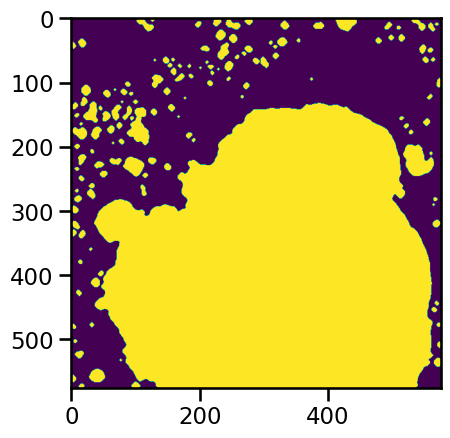

In [251]:
plt.imshow(segm_alg(new_image))